# Table: Homogeneous Programs

This workbook explores the program table, which contains the information corresponding to the syntactic constructions of programs. The first thing we do is to configure the notebook execution environment, for this we define some constants and properties that will be used in the future.

In [4]:
# Notebook parameters ans set up
import sys
import os
import dataset.db.db_utils as db_utils

# Database connection properties
DB_CONNECTION_STR = f"postgresql://{db_utils.connection_string['user']}:{db_utils.connection_string['password']}@{db_utils.connection_string['host']}:{db_utils.connection_string['port']}/{db_utils.connection_string['dbname']}"

# Table name, features and target.
TABLE_NAME = 'programs'
TABLE_FEATURES = ['program__program_id','program__name','program__has_sub_dirs_with_code','program__has_packages','program__number_of_modules','program__number_of_sub_dirs_with_code','program__number_of_packages','program__class_defs_pct','program__function_defs_pct','program__enum_defs_pct','program__has_code_root_package','program__average_defs_per_module','program__user_id','program__expertise_level']
TABLE_TARGET = 'program__expertise_level'

# Directory to store the results.
RESULTS_FOLDER_DIR = './results'
if not os.path.exists(RESULTS_FOLDER_DIR):
    os.makedirs(RESULTS_FOLDER_DIR)

# Data Fetching

To download the dataset we make use of a SQL statement that is launched against the PostgresSQL database that we have up with all the data resulting from the extraction.

In [5]:
import pandas as pd
import psycopg2
import sqlalchemy

db_connection = sqlalchemy.create_engine(DB_CONNECTION_STR)

sql_query = open(file='./queries/programs.sql', mode='r').read()
full_table = pd.read_sql_query(sql=sql_query, con=db_connection)

# Load features and target.
X, y = full_table[TABLE_FEATURES], full_table[[TABLE_TARGET]].iloc[:,0]

# Print information about the loaded table.
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

Features shape: (1609, 14)
Target shape: (1609,)


As we can see the downloaded data contains a total of 1609 instances. Each of the instances corresponds to a program. For each program we have 14 attributes.

## Data Exploration

Once we have download our data we have to check the shape of the data, if it contains null or repeated values among other things.

In [3]:
print(X.info())
print('=============')
print(y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4651 entries, 0 to 4650
Data columns (total 7 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   program__percentage_of_classes                   4651 non-null   float64
 1   program__percentage_of_interfaces                4651 non-null   float64
 2   program__percentage_of_enums                     4651 non-null   float64
 3   program__contains_code_in_packages               4651 non-null   bool   
 4   program__contains_code_in_default_package        4651 non-null   bool   
 5   program__percentage_of_types_in_packages         4651 non-null   float64
 6   program__percentage_of_types_in_default_package  4651 non-null   float64
dtypes: bool(2), float64(5)
memory usage: 190.9 KB
None
<class 'pandas.core.series.Series'>
RangeIndex: 4651 entries, 0 to 4650
Series name: program__user_class
Non-Null Count  Dtype 
--------

As we can see the programs table contains 7 features from which only two are boolean and the other are numeric. From all the entries 4651 none is null.

In [4]:
instances_for_class_low = len(full_table[full_table[TABLE_TARGET] == "low"])
instances_for_class_high = len(full_table[full_table[TABLE_TARGET] == "high"])

print(f"The dataset contains {instances_for_class_low/len(full_table)*100:.4}% instances for low class and {instances_for_class_high/len(full_table)*100:.4}% for high class.")

The dataset contains 97.08% instances for low class and 2.924% for high class.


As we can see this is a very unbalanced dataset.

In [5]:
number_of_duplicated_entries = sum(full_table.duplicated(subset=TABLE_FEATURES + [TABLE_TARGET]))
pctg_of_duplicated_entries = number_of_duplicated_entries / len(full_table) * 100
print(f"The dataset contains [{pctg_of_duplicated_entries:.4}%] of duplicated entries.")

The dataset contains [93.4%] of duplicated entries.


As we can see 93.4% are a lot of duplicated entries. Duplicate entries are problematic for multiple reasons. First off, when an entry appears more than once, it receives a disproportionate weight during training. Thus models that succeed on frequent entries will look like they perform well, while in reality this is not the case. Additionally, duplicate entries can ruin the split between train, validation and test sets in cases where identical entries are not all in the same set. This can lead to biased performance estimates that will lead to disappointing models in production.

In order to remove the duplicated entries we have performed an SQL job that computed which instance of all the repeated ones has to survive. In our case this is done by means of frequescies. That is, the group of programmers that code a pattern more than 1/3 than the other group would pass the filter. Otherwise both instances would be removed.

In [6]:
NAME_OF_DATABASE_WO_DUPLICATES = 'patternminingV2' # This database contains non-duplicated instances.
CONNECTION_STR_OF_DATABASE_WO_DUPLICATES = f"postgresql://{DATABASE_USERNAME}:{DATABASE_PASSWORD}@{DATABASE_IP}:{DATABASE_PORT}/{NAME_OF_DATABASE_WO_DUPLICATES}"

connection_to_db_wo_duplicates = sqlalchemy.create_engine(CONNECTION_STR_OF_DATABASE_WO_DUPLICATES)

sql_query = open(file='../03_queries/programs_unique.sql', mode='r').read()
full_table_wo_duplicates = pd.read_sql_query(sql=sql_query, con=connection_to_db_wo_duplicates)

# Load features and target.
X_wo_duplicates, y_wo_duplicates = full_table_wo_duplicates[TABLE_FEATURES], full_table_wo_duplicates[[TABLE_TARGET]].iloc[:,0]

# Print information about the loaded table.
print(f'Features shape: {X_wo_duplicates.shape}')
print(f'Target shape: {y_wo_duplicates.shape}')

Features shape: (305, 7)
Target shape: (305,)


In [7]:
print(X_wo_duplicates.info())
print('=============')
print(y_wo_duplicates.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 7 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   program__percentage_of_classes                   305 non-null    float64
 1   program__percentage_of_interfaces                305 non-null    float64
 2   program__percentage_of_enums                     305 non-null    float64
 3   program__contains_code_in_packages               305 non-null    bool   
 4   program__contains_code_in_default_package        305 non-null    bool   
 5   program__percentage_of_types_in_packages         305 non-null    float64
 6   program__percentage_of_types_in_default_package  305 non-null    float64
dtypes: bool(2), float64(5)
memory usage: 12.6 KB
None
<class 'pandas.core.series.Series'>
RangeIndex: 305 entries, 0 to 304
Series name: program__user_class
Non-Null Count  Dtype 
-------------

As we can see now we have loaded the dataset without duplicates. This dataset will be only used for clasification, that is the logistic regression.

In [8]:
instances_for_class_low = len(full_table_wo_duplicates[full_table_wo_duplicates[TABLE_TARGET] == "low"])
instances_for_class_high = len(full_table_wo_duplicates[full_table_wo_duplicates[TABLE_TARGET] == "high"])

print(f"The dataset contains {instances_for_class_low/len(full_table_wo_duplicates)*100:.4}% instances for low class and {instances_for_class_high/len(full_table_wo_duplicates)*100:.4}% for high class.")

The dataset contains 56.07% instances for low class and 43.93% for high class.


Even our raw dataset was very unbalanced, after deduplication of instances we get a balanced dataset.

# Data Preprocessing

Once our data has been downloaded we need to explore it and apply any required preprocess.

## Data types normalization

Firs we will make sure that our data contains the same type of data on each column. For that we will apply one hot encoding so that categorical features are transformed in to boolean columns and then we will transform every column to float32 type of data.

In [9]:
def normalize_datatypes(X: pd.DataFrame, y: pd.Series) -> (pd.DataFrame, pd.Series, [str]):
    X = pd.get_dummies(X)
    X = X.astype('float32')
    y = y.apply(lambda value: 0 if value == "low" else 1) # high will be 1 and low will be 0.
    y = y.astype('float32')
    columns_names = X.columns.tolist()
    return X, y, columns_names

X, y, TABLE_FEATURES = normalize_datatypes(X, y)
X_wo_duplicates, y_wo_duplicates, _ = normalize_datatypes(X_wo_duplicates, y_wo_duplicates)

# Print information about the loaded table.
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

Features shape: (4651, 7)
Target shape: (4651,)


## Outlier Analysis

Our dataset contains raw data. That is, no cleaning has been done. Therefore we must detect and remove outliers that might have an impact in future algorithms like clustering or PCA. For that we will apply outlier detection and removal of both univariable and multivariable features.

### Univariable

In [10]:
import numpy as np

Z_SCORE_THRESHOLD = 10

z_scores = np.abs((X - X.mean())/X.std(ddof=0)).fillna(0.0)
univar_outliers = X[(z_scores >= Z_SCORE_THRESHOLD).any(axis=1)].index.tolist()
full_table.iloc[univar_outliers]

,program__program_id,program__percentage_of_classes,program__percentage_of_interfaces,program__percentage_of_enums,program__contains_code_in_packages,program__contains_code_in_default_package,program__percentage_of_types_in_packages,program__percentage_of_types_in_default_package,program__user_id,program__user_class
1185,3393,0.000000,100.000000,0.0,True,False,100.0,0.0,a286,low
4204,2141,0.000000,100.000000,0.0,True,False,100.0,0.0,a215,low
4415,23,58.333333,4.166667,37.5,True,False,100.0,0.0,aws,high


Three univariate outliers were identified. Of which 2 are due to methodological errors and 1 corresponds to a program of a high user where there is a very high atypical portage of enumerations. For some of the following algorithms we have proceeded to eliminate those instances that were derived from methodological errors.

### Multivariable

In [11]:
from sklearn.ensemble import  IsolationForest

CONTAMINATION_FACTOR = 0.0012

isof_model = IsolationForest(contamination=CONTAMINATION_FACTOR, random_state=0)
isof_prediction = isof_model.fit_predict(X.to_numpy())
mask = isof_prediction == -1
multivar_outliers = X[mask].index.tolist()
full_table.iloc[multivar_outliers]

,program__program_id,program__percentage_of_classes,program__percentage_of_interfaces,program__percentage_of_enums,program__contains_code_in_packages,program__contains_code_in_default_package,program__percentage_of_types_in_packages,program__percentage_of_types_in_default_package,program__user_id,program__user_class
806,575,87.500000,0.000000,12.5,True,True,87.0,12.0,a122,low
1185,3393,0.000000,100.000000,0.0,True,False,100.0,0.0,a286,low
1763,2830,33.333333,66.666667,0.0,True,False,100.0,0.0,a253,low
2707,3300,33.333333,66.666667,0.0,True,False,100.0,0.0,a279,low
4204,2141,0.000000,100.000000,0.0,True,False,100.0,0.0,a215,low
4218,300,33.333333,66.666667,0.0,True,False,100.0,0.0,a108,low


In the case of multivariate outliers we found a total of 6 instances. Of these 6, and after analyzing the reason in detail, we found 4 more instances, belonging to low users, which correspond to methodological errors (incomplete code).

### Outlier removal

As already mentioned, those outliers that correspond to methodological errors we will proceed to eliminate them from our data set to prevent them from having an influence on the algorithms we will apply in the future.

In [12]:
print(f'Original features shape: {X.shape}')
print(f'Original target shape: {y.shape}')
outliers_ids = [806, 1185, 1763, 2707, 4204, 4218]
X = X.drop(outliers_ids, axis=0)
y = y.drop(outliers_ids, axis=0)
print(f'New features shape: {X.shape}')
print(f'New target shape: {y.shape}')

Original features shape: (4651, 7)
Original target shape: (4651,)
New features shape: (4645, 7)
New target shape: (4645,)


## Data Scaling

Now we have a dataset where all the columns contain the same type of data (float32) and where both, univariable and multivariable, outliers have been removed. Unfortunately the columns of out dataset are still in different scales. For example percentages are in scale 0-100 meanwhile boolean features are in scale 0-1. In order to fix that we will transform every feature to range 0-1. In the case of the percentages 100 will be map to 1 and 0 to 0. In the case of boolean features no transformation is required. Finally, other features will be scaled as value / max value of the feature, so that max value is mapped to 1.

In [13]:
PERCENTAGE_COLUMNS = ['type_def__percentage_overloaded_methods', 'type_def__percentage_of_static_fields',
                      'type_def__percentage_of_static_methods']

def scale_data_to_range_0_1(X: pd.DataFrame, feature_names: [str], percentage_feature_names: [str]) -> pd.DataFrame:
    for column in feature_names:
        if column in percentage_feature_names:
            X[column] = X[column] / 100.0
        else:
            X[column] = X[column] / X[column].max()
    X = X.fillna(0.0)
    return X

X = scale_data_to_range_0_1(X, TABLE_FEATURES, PERCENTAGE_COLUMNS)
X_wo_duplicates = scale_data_to_range_0_1(X_wo_duplicates, TABLE_FEATURES, PERCENTAGE_COLUMNS)

# Data Visualization

Currently our data has more than 3 dimensions. This makes visualization and premature pattern detection by the human eye very difficult. For this we will apply a set of dimensionality reduction algorithms and then visualize the resulting data.

In [14]:
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA, NMF


def visualize_dataset(X: pd.DataFrame, y:pd.Series) -> None:
    if len(X) > 50000:
        print(f"Sampling data to 50.000 instances before ploting")
        X = X.sample(n=50000, random_state=0)
        y = y[X.index]

    # Init the figure that will hold all subplots.
    figure, axis = plt.subplots(2, 2)
    figure.set_figwidth(18)
    figure.set_figheight(18)

    # PCA
    tmp_model = PCA(n_components=2)
    X_embedded = tmp_model.fit_transform(X)
    explained_variance = np.cumsum(tmp_model.explained_variance_ratio_)[1]  # dimention 2 (it is cumulative sum)
    # plot it
    axis[0, 0].set_title(f"Linear PCA. Exp.var:{explained_variance:.4f}%.")
    axis[0, 0].scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='viridis', alpha=0.2)

    # TSNE
    tmp_model = TSNE(n_components=2, init='random', learning_rate=200, random_state=0)
    X_embedded = tmp_model.fit_transform(X)
    # plot it
    axis[0, 1].set_title(f"t-SNE.")
    axis[0, 1].scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='viridis', alpha=0.2)

    # KernelPCA
    tmp_model = KernelPCA(n_components=2, kernel="rbf")
    X_embedded = tmp_model.fit_transform(X)
    # plot it
    axis[1, 0].set_title(f"KernelPCA.")
    axis[1, 0].scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='viridis', alpha=0.2)

    # NMF
    tmp_model = NMF(n_components=2, init='random', random_state=0, max_iter=5000)
    X_embedded = tmp_model.fit_transform(X)
    # plot it
    axis[1, 1].set_title(f"NMF for.")
    axis[1, 1].scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='viridis', alpha=0.2)

    plt.show()

With duplicates

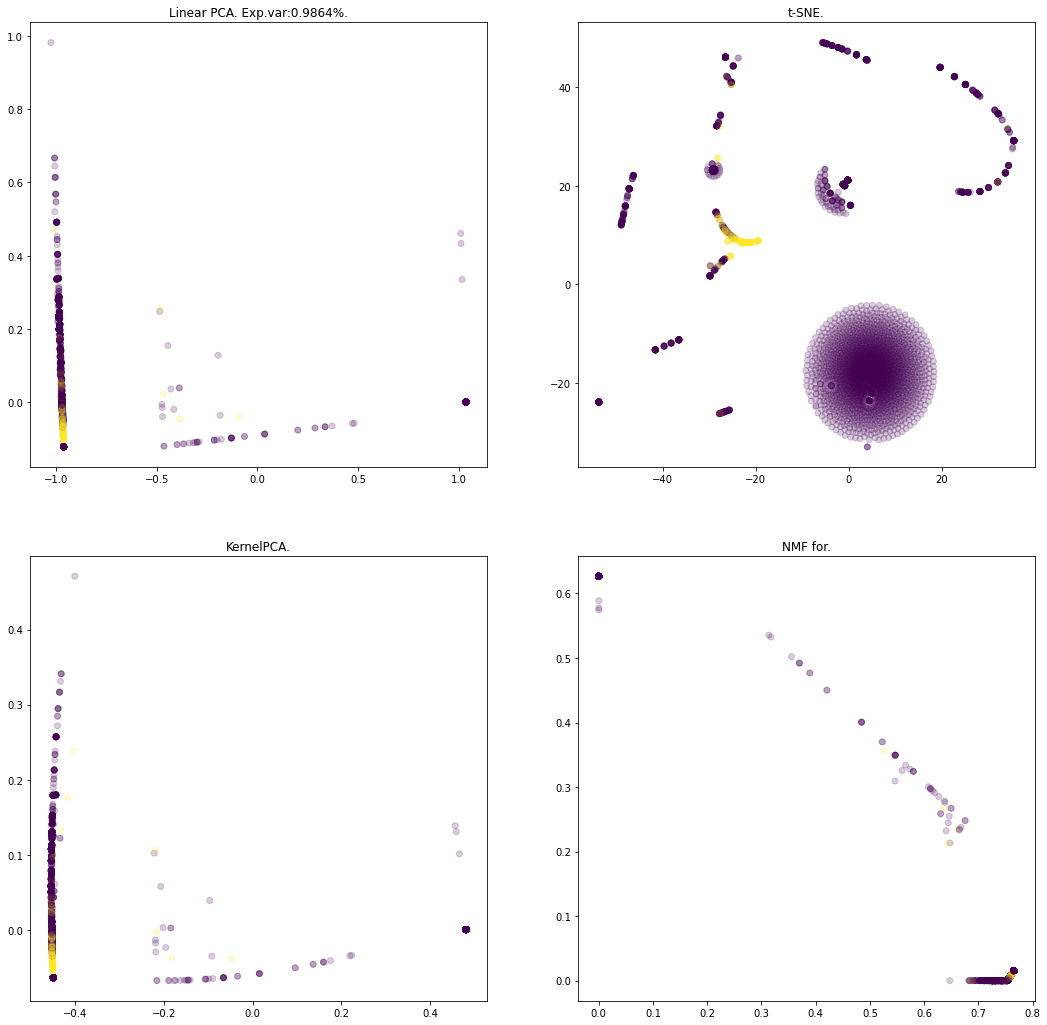

In [15]:
visualize_dataset(X,y)

Without duplicates

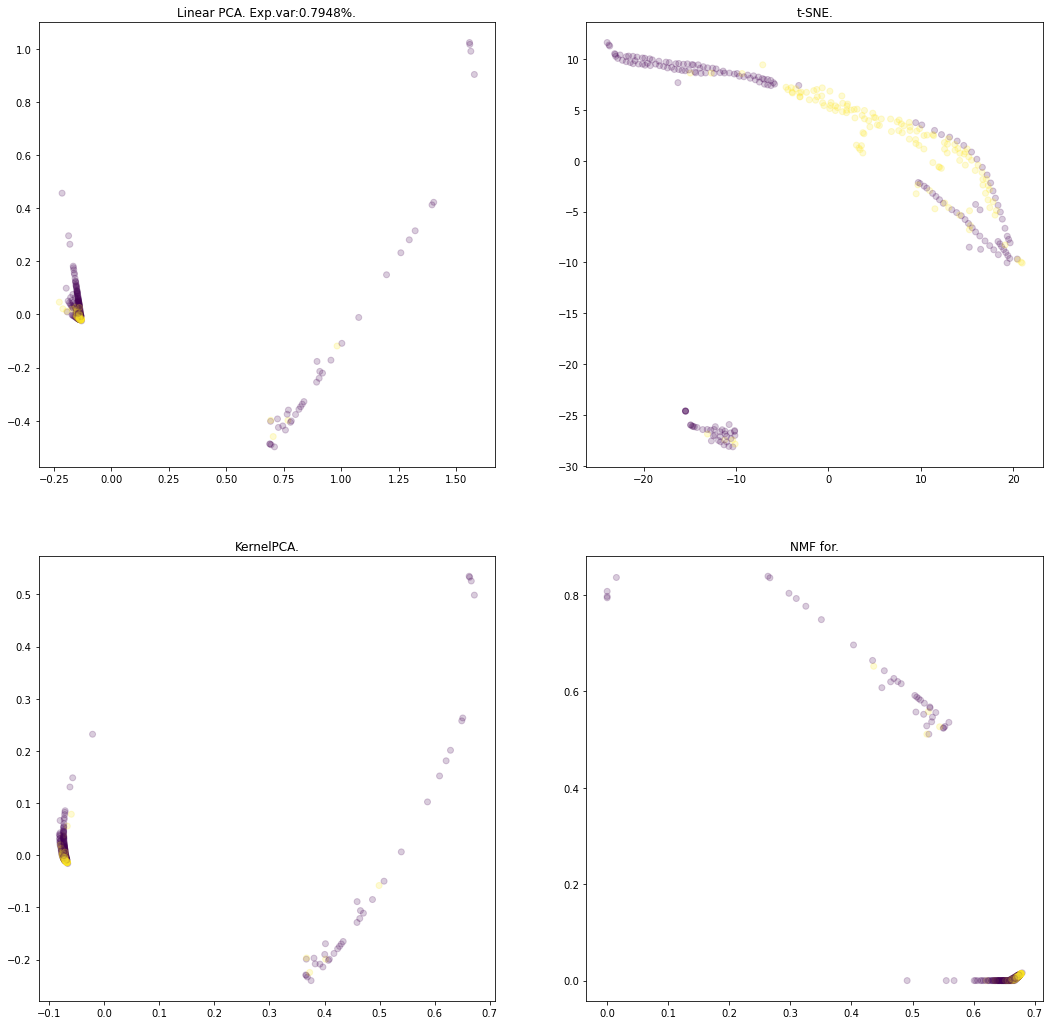

In [16]:
visualize_dataset(X_wo_duplicates, y_wo_duplicates)

# ElasticNet Model

Another way we can see if our data contains information about the level of experience of the programmers is to train a classifier and evaluate it. In our case we will use a logistic regression with elastic net penalty, similar to a lasso regression. In this way we will not only be able to evaluate whether or not the data allow us to classify but also to obtain a weight for each characteristic that indicates its association with the level of experience.

⚠️ The elasticnet model needs to be trained with the data dedupicated.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
import numpy as np


def train_and_evaluate_elnet(X: pd.DataFrame, y: pd.Series) -> BaseEstimator:
    # Print input shape.
    print(f'Features input shape: {X.shape}')
    print(f'Target input shape: {y.shape}')
    
    # Split the dataset in train test.
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

    # Instantiate the model.
    elnet_model = LogisticRegression(max_iter=10000, solver='saga',
                                     penalty='elasticnet', l1_ratio=0.0,
                                     n_jobs=-1, random_state=0)

    # Search grid and grid search instance.
    grid={"C":np.logspace(-4,4,10), "l1_ratio":np.arange(0, 1, 0.1, dtype=float)}
    logreg_cv=GridSearchCV(elnet_model, grid, cv=10, n_jobs=-1, verbose=1)
    logreg_cv.fit(X_train, y_train)

    print("Tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)

    # Evaluate the model.
    y_pred = logreg_cv.predict(X_test)
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Reacall: ', recall_score(y_test, y_pred))
    print('Precision score: ', precision_score(y_test, y_pred))
    print('F1 score: ', f1_score(y_test, y_pred))
    
    return logreg_cv.best_estimator_

With duplicates

In [19]:
best_estimator = train_and_evaluate_elnet(X, y)

# Save the coeficients to excel.
tmp_df = pd.DataFrame(best_estimator.coef_).T
tmp_df['features'] = TABLE_FEATURES
tmp_df.to_excel(excel_writer = f"{RESULTS_FOLDER_DIR}/{TABLE_NAME}_elnet_coefs.xlsx")

Features input shape: (4645, 7)
Target input shape: (4645,)
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


exception calling callback for <Future at 0x7f8018a50910 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/virtualuser/anaconda3/envs/ml-py38/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py", line 407, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/home/virtualuser/anaconda3/envs/ml-py38/lib/python3.8/multiprocessing/queues.py", line 102, in get
    if not self._rlock.acquire(block, timeout):
KeyboardInterrupt
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/virtualuser/anaconda3/envs/ml-py38/lib/python3.8/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/home/virtualuser/anaconda3/envs/ml-py38/lib/python3.8/site-packages/joblib/parallel.py", line 359, in __call__
    self.parallel.dispatch_next

KeyboardInterrupt: 

Without duplicates

In [19]:
best_estimator = train_and_evaluate_elnet(X_wo_duplicates, y_wo_duplicates)

# Save the coeficients to excel.
tmp_df = pd.DataFrame(best_estimator.coef_).T
tmp_df['features'] = TABLE_FEATURES
tmp_df.to_excel(excel_writer = f"{RESULTS_FOLDER_DIR}/{TABLE_NAME}_elnet_coefs_wo_duplicates.xlsx")

Features input shape: (305, 7)
Target input shape: (305,)
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Tuned hpyerparameters :(best parameters)  {'C': 0.3593813663804626, 'l1_ratio': 0.0}
Accuracy:  0.7704918032786885
Reacall:  0.8518518518518519
Precision score:  0.696969696969697
F1 score:  0.7666666666666667


# Data Clustering

To perform the clustering in an unsupervised way we will use an unsupervised clustering algorithm such as KMeans. In the case of KMeans it is necessary to give a number of clusters to perform (k). To choose that number we will use the elbow rule. Once we obtain that number we will explore the resulting clusters and identify the variables that identify each of the clusters. In the case of numerical variables we will use Tukey's test to see if there are significant differences of that centroid between the different clusters (if there are significant differences with all the other clusters, then that variable identifies the cluster to which it belongs). In the case of categorical and boolean variables (yes/no) we do it visually, taking into account that a centroid is a mean value and that a boolean variable can only take values 1 or 0. However, to be able to do this analysis visually, in those clusters with more than 40 variables we have to perform a feature selection. So that these can be visualized in a single graph.

## KMeans elbow

To obtain the elbow we will use an instance of KElbowVisualizer that allows us to calculate and display the exploration of N KMeans clusters.

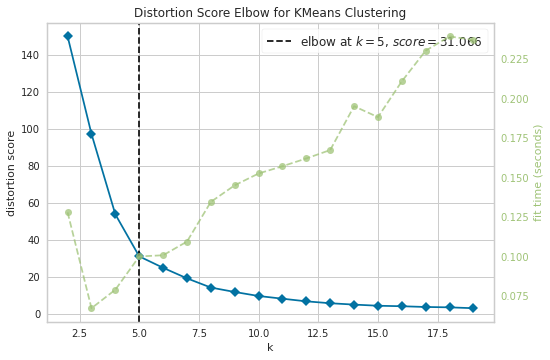

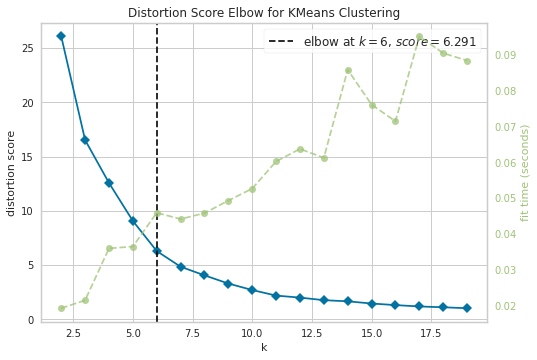

In [14]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

def compute_and_plot_kmeans_elbow(X: pd.DataFrame, from_n_clusters: int, to_n_clusters: int) -> int:
    tmp_model = KMeans()
    # k is range of number of clusters.
    visualizer = KElbowVisualizer(tmp_model, k=(from_n_clusters,to_n_clusters), timings= True)
    visualizer.fit(X)
    visualizer.show()
    
    return visualizer.elbow_value_

# Store the elbow index for later use.
KMEANS_ELBOW = compute_and_plot_kmeans_elbow(X, 2, 20)

KMEANS_ELBOW_WO_DUPLICATES = compute_and_plot_kmeans_elbow(X_wo_duplicates, 2, 20)

As we can see, in this case the number of clusters indicated by the elbow rule is 5. So let's explore these 5 clusters and see not only what they represent but also whether they are associated with the programmer's level of experience or not.

In [23]:
# Define numeric features to explore with tukey method.
TABLE_NUMERIC_FEATURES = ['program__percentage_of_classes', 'program__percentage_of_interfaces',
                          'program__percentage_of_enums', 'program__percentage_of_types_in_packages',
                          'program__percentage_of_types_in_default_package']

def find_features_that_identify_clusters(n_clusters: int, X: pd.DataFrame, numeric_feature_names: [str]) -> [str]:
    kmeans_model = KMeans(random_state=0, n_clusters=KMEANS_ELBOW)
    X_labels = kmeans_model.fit_predict(X)
    X_labelled = X.copy()
    X_labelled['cluster_id'] = X_labels
    
    kmeans_centroids = []
    features = []
    
    # Get non numeric features
    for feature_name in TABLE_FEATURES:
        if feature_name not in numeric_feature_names:
            features.append(feature_name)
    
    # Get centroids
    for current_cluster_index in range(kmeans_model.n_clusters):
        # Cluster support computing.
        current_cluster_individuals = X_labelled[X_labelled['cluster_id'] == current_cluster_index]
        current_cluster_centroids = []
        for feature_name in TABLE_FEATURES:
            if feature_name not in numeric_feature_names:
                centroid = current_cluster_individuals[feature_name].mean()
                centroid = centroid > 0.5
                current_cluster_centroids.append(centroid)
                
        kmeans_centroids.append(current_cluster_centroids)
        
    # Compute how many features we need to identify the clusters
    centroids = pd.DataFrame(kmeans_centroids, columns = features)
    
    subset_of_features = []
    for feature_name in features:
        subset_of_features.append(feature_name)
        duplicated_rows = centroids.duplicated(subset=subset_of_features)
        if sum(duplicated_rows) == 0:
            print(f"You can identify all the clusters with {subset_features}.")
            return subset_features
    print("The provided model cannot be identified only with boolean features.")

find_features_that_identify_clusters(KMEANS_ELBOW, X, TABLE_NUMERIC_FEATURES)

The provided model cannot be identified only with boolean features.


In [27]:
from statsmodels.stats import weightstats as stests
from scipy.stats import t

def explore_kmeans_distributions_and_centroids(n_clusters: int, X: pd.DataFrame,
                                               y: pd.Series, numeric_feature_names: [str]) -> None:
    # KMeans model created and fitted with the number of clsuters resulted from the elbow.
    kmeans_model = KMeans(random_state=0, n_clusters=KMEANS_ELBOW)
    X_labels = kmeans_model.fit_predict(X)
    X_labelled = X.copy()
    X_labelled['cluster_id'] = X_labels

    # Temporal array to store the supports (% population) that clusters associated with an expertise level have.
    supports_of_clusters_associated_with_an_expertise_level = []


    # Explore each one of the clusters (supports and tukey test).
    for current_cluster_index in range(kmeans_model.n_clusters):
        # Cluster support computing.
        current_cluster_individuals = X_labelled[X_labelled['cluster_id'] == current_cluster_index]
        support = len(current_cluster_individuals) / len(X)*100
        current_cluster_individuals = pd.concat([current_cluster_individuals, y], axis=1, join='inner')
        lows = current_cluster_individuals[current_cluster_individuals['program__user_class'] == 0]
        highs = current_cluster_individuals[current_cluster_individuals['program__user_class'] == 1]
        lows_pct = len(lows) / len(current_cluster_individuals)*100
        highs_pct = len(highs) / len(current_cluster_individuals) * 100

        if lows_pct > 70.0 or highs_pct > 70.0:
            print(f"Cluster [{current_cluster_index}]. Support [{support:.4f}]. Lows [{lows_pct:.4f}]. Highs [{highs_pct:.4f}]. (*)")
            supports_of_clusters_associated_with_an_expertise_level.append(support)
        else:
            print(f"Cluster [{current_cluster_index}]. Support [{support:.4f}]. Lows [{lows_pct:.4f}]. Highs [{highs_pct:.4f}].")

        # Tukey test to identify variables that identify the cluster.
        for current_feature in numeric_feature_names:

            p_values_less_than_0_05 = []
            for other_cluster_index in range(kmeans_model.n_clusters):
                other_cluster_individuals = X_labelled[X_labelled['cluster_id'] == other_cluster_index]

                if current_cluster_index != other_cluster_index:
                    column_from_current_cluster = current_cluster_individuals[current_feature]
                    column_from_other_cluster = other_cluster_individuals[current_feature]
                    ttest, p_value, df = stests.ttest_ind(column_from_current_cluster, column_from_other_cluster)
                    p_values_less_than_0_05.append(p_value < 0.05)

            m = current_cluster_individuals[current_feature].mean()
            s = current_cluster_individuals[current_feature].std()
            dof = len(current_cluster_individuals[current_feature]) - 1
            confidence = 0.95
            t_crit = np.abs(t.ppf((1 - confidence) / 2, dof))
            low_ci, high_ci = (m - s * t_crit / np.sqrt(len(current_cluster_individuals[current_feature])), 
                               m + s * t_crit / np.sqrt(len(current_cluster_individuals[current_feature])))
            if sum(p_values_less_than_0_05) == len(p_values_less_than_0_05):
                print(f"\tIdentified by feature [{current_feature}]. Range [{low_ci} - {high_ci}].")

    aggregated_support_of_clusters_associated_with_an_expertise_level = sum(supports_of_clusters_associated_with_an_expertise_level)
    print(f"Support of clusters associated with a level of experience: {sum(supports_of_clusters_associated_with_an_expertise_level):.4f}.")


With duplicates

In [28]:
# Define numeric features to explore with tukey method.
TABLE_NUMERIC_FEATURES = ['program__percentage_of_classes', 'program__percentage_of_interfaces',
                          'program__percentage_of_enums', 'program__percentage_of_types_in_packages',
                          'program__percentage_of_types_in_default_package']

explore_kmeans_distributions_and_centroids(KMEANS_ELBOW, X, y, TABLE_NUMERIC_FEATURES)

Cluster [0]. Support [32.3358]. Lows [93.0093]. Highs [6.9907]. (*)
	Identified by feature [program__percentage_of_classes]. Range [0.983631830725536 - 0.9864036030436901].
	Identified by feature [program__percentage_of_enums]. Range [0.0070634469069979795 - 0.010056759821579634].
Cluster [1]. Support [47.8794]. Lows [100.0000]. Highs [0.0000]. (*)
	Identified by feature [program__percentage_of_classes]. Range [0.99935761062069 - 1.000042409025001].
	Identified by feature [program__percentage_of_interfaces]. Range [-7.073769072395077e-05 - 0.0010706063053230594].
	Identified by feature [program__percentage_of_enums]. Range [0.0 - 0.0].
	Identified by feature [program__percentage_of_types_in_packages]. Range [0.0 - 0.0].
	Identified by feature [program__percentage_of_types_in_default_package]. Range [1.0 - 1.0].
Cluster [2]. Support [7.7718]. Lows [99.4460]. Highs [0.5540]. (*)
	Identified by feature [program__percentage_of_classes]. Range [0.7952789098557136 - 0.8100084036055901].
	Ide

Without duplicates

In [22]:
# Define numeric features to explore with tukey method.
TABLE_NUMERIC_FEATURES = ['program__percentage_of_classes', 'program__percentage_of_interfaces',
                          'program__percentage_of_enums', 'program__percentage_of_types_in_packages',
                          'program__percentage_of_types_in_default_package']

explore_kmeans_distributions_and_centroids(KMEANS_ELBOW_WO_DUPLICATES, X_wo_duplicates, y_wo_duplicates, TABLE_NUMERIC_FEATURES)

Cluster [0]. Support [7.5410]. Lows [82.6087]. Highs [17.3913]. (*)
	Identified by feature [program__percentage_of_classes]. Range [0.7294598451095051 - 0.7969611057800823].
	Identified by feature [program__percentage_of_enums]. Range [0.37409148920567115 - 0.5384512115618459].
Cluster [1]. Support [9.8361]. Lows [86.6667]. Highs [13.3333]. (*)
	Identified by feature [program__percentage_of_types_in_packages]. Range [0.7964527138838912 - 0.9002140036454057].
	Identified by feature [program__percentage_of_types_in_default_package]. Range [0.09286346919948404 - 0.19646987430637533].
Cluster [2]. Support [9.5082]. Lows [100.0000]. Highs [0.0000]. (*)
	Identified by feature [program__percentage_of_classes]. Range [0.6070072870781652 - 0.7379787940451868].
	Identified by feature [program__percentage_of_interfaces]. Range [0.2620212357571356 - 0.39299274272415713].
Cluster [3]. Support [69.8361]. Lows [40.8451]. Highs [59.1549].
	Identified by feature [program__percentage_of_enums]. Range [0

In this case we have a data set for which we always find at least one numerical feature that identifies the groupings. Therefore it is not necessary to perform the second point where we visually identify a boolean feature (categorical with onehot) to identify the clustering.

### KMeans Centroids

In this example looks like the elbow is located at 5 clusters, so lets explore that KMeans model.

In [24]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

def plot_cluster_model_centroids(model, data_to_fit: pd.DataFrame, population: pd.DataFrame, target):
    
    # Cluster computations.
    prediction = model.fit(data_to_fit)
    cluster_labels = [label for label in set(prediction.labels_) if label > -1]
    number_of_clusters = len(cluster_labels)
    population = population.copy()
    population['cluster_n'] = prediction.labels_
    
    # Init matplotlib main figure and subfigures
    fig = plt.figure(figsize=(40, 2*number_of_clusters))
    #fig.suptitle(f"Centroids of {model.__class__.__name__} model over {data_to_fit.shape[1]} dimensions for n_clusters={number_of_clusters} and table={table_name}",fontsize=12,)
    subfigs = fig.subfigures(1, 2, wspace=0, width_ratios=[20., 1.])
    
    # Centroids figure configuration
    subfigs[0].suptitle(f"Centroids of {model.__class__.__name__} model over {data_to_fit.shape[1]} dimensions for n_clusters={number_of_clusters} and table={TABLE_NAME}", fontsize=18)
    #subfigs[0].supxlabel('Features')
    
    # Create rows for centroids figure
    gs0 = subfigs[0].add_gridspec(number_of_clusters, hspace=0.1)
    axis0 = gs0.subplots(sharex=True, sharey=True)
    
    # Distributions figure configuration
    subfigs[1].suptitle('User Class', fontsize=18)
    
    # Create rows for centroids figure
    gs1 = subfigs[1].add_gridspec(number_of_clusters, hspace=0.1)
    axis1 = gs1.subplots(sharex=True, sharey=True)
    
    # Explore each one of the clusters of the selected model.
    for cluster_n in range(number_of_clusters):
        
        # Get the population from the cluster and remove the cluster number column
        individuals_in_cluster = population[population['cluster_n'] == cluster_n].loc[ : , population.columns != 'cluster_n']
        
        # Compute the centroids of each cluster as the means of each column and its std.
        individuals_means = individuals_in_cluster.describe().loc[['mean']].values.tolist()[0]
        individuals_stds = individuals_in_cluster.describe().loc[['std']].values.tolist()[0]
        
        # Add the user_class column to the individuals in the cluster.
        individuals_in_cluster = pd.concat([individuals_in_cluster, target], axis=1, join='inner')
        
        # Get the percentage of population in the cluster
        individuals_in_cluster_n = len(individuals_in_cluster)
        individuals_in_cluster_pctg = individuals_in_cluster_n / len(population)*100
        
        # Get the percentage of low individuals from the total in the cluster
        low_individuals_in_cluster_n = len(individuals_in_cluster[individuals_in_cluster['program__user_class'] == 0])
        low_individuals_in_cluster_pctg = low_individuals_in_cluster_n / len(target[target == 0])*100
        
        # Get the percentage of high individuals from the total in the cluster
        high_individuals_in_cluster_n = len(individuals_in_cluster[individuals_in_cluster['program__user_class'] == 1])
        high_individuals_in_cluster_pctg = high_individuals_in_cluster_n / len(target[target == 1])*100
        
        # Get the percentage of low individuals from the cluster individuals
        low_individuals_in_cluster_rel_pctg = low_individuals_in_cluster_n / individuals_in_cluster_n*100
        
        # Get the percentage of high individuals from the cluster individuals
        high_individuals_in_cluster_rel_pctg = high_individuals_in_cluster_n / individuals_in_cluster_n*100
        
        #print(f"Cluster {cluster_n+1}. individuals_in_cluster_pctg:{individuals_in_cluster_pctg:6.2f}, low_individuals_in_cluster_pctg:{low_individuals_in_cluster_pctg:6.2f}, high_individuals_in_cluster_pctg:{high_individuals_in_cluster_pctg:6.2f}, low_individuals_in_cluster_rel_pctg:{low_individuals_in_cluster_rel_pctg:6.2f}, high_individuals_in_cluster_rel_pctg:{high_individuals_in_cluster_rel_pctg:6.2f}.")
        
        # Matplotlib code
        col_map = plt.get_cmap('Paired')
        col_map_2 = plt.get_cmap('Set2')
        axis0[cluster_n].bar(TABLE_FEATURES, individuals_means, yerr=individuals_stds, color=col_map.colors)
        axis0[cluster_n].legend([f"Cluster number {cluster_n + 1}"], loc='upper right')
        axis0[cluster_n].tick_params(labelrotation=90)
        axis0[cluster_n].grid(color='gray', linestyle='-', linewidth=0.1)
        axis1[cluster_n].bar(['low', 'high'],[low_individuals_in_cluster_rel_pctg, high_individuals_in_cluster_rel_pctg], color=col_map_2.colors)
        axis1[cluster_n].grid(color='gray', linestyle='-', linewidth=0.1)
        axis1[cluster_n].tick_params(labelrotation=90)

    # Hide x labels and tick labels for all but bottom plot.
    for ax in axis0:
        ax.label_outer()
    for ax in axis1:
        ax.label_outer()
        ax.get_yaxis().set_visible(False)

    plt.subplots_adjust(left = 0., right = 0.995, top = 0.95, bottom=0.00, hspace=110, wspace=0.0)
    plt.show()
    #fig.savefig(job_folder+f"/{table_name}_centroids_{model.__class__.__name__}_{data_to_fit.shape[1]}_dims.svg", bbox_inches="tight")
    
    
# Save the results into an excel file
def store_kmeans_model_results(model, filename: str):
    df = pd.DataFrame(model.cluster_centers_, columns=model.feature_names_in_)
    df.to_excel(excel_writer = f"{job_folder}/{filename}_results.xlsx")
    
def store_kmeans_labeled_data(model, data):
    labeled_X = data.copy()
    labeled_X['cluster_id'] = model.predict(labeled_X)
    #labeled_X.to_csv(f"{job_folder}/{table_name}_kmeans_labeled.csv")

With duplicates

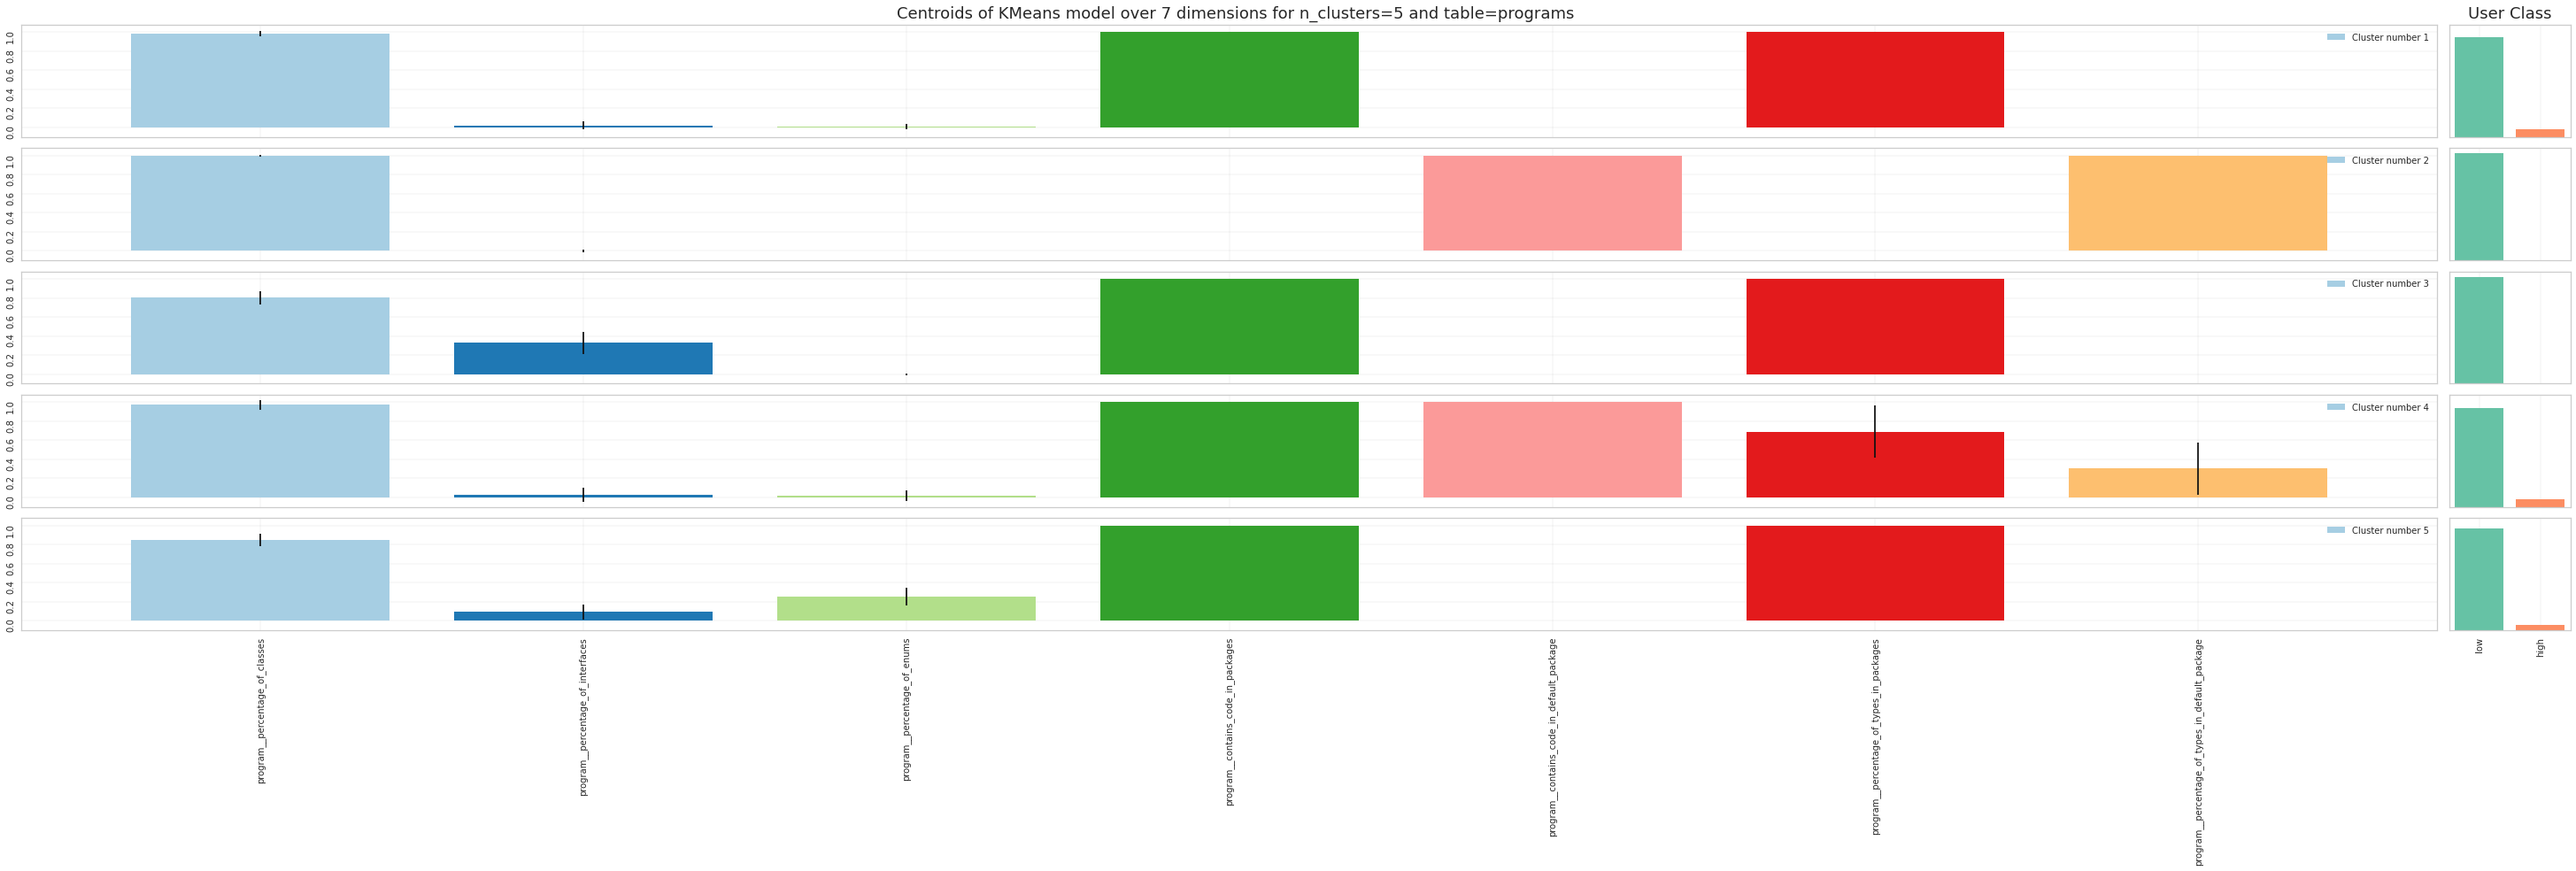

In [25]:
kmeans_model = KMeans(random_state=0, n_clusters=KMEANS_ELBOW)

plot_cluster_model_centroids(kmeans_model, X, X, y)

Without duplicates

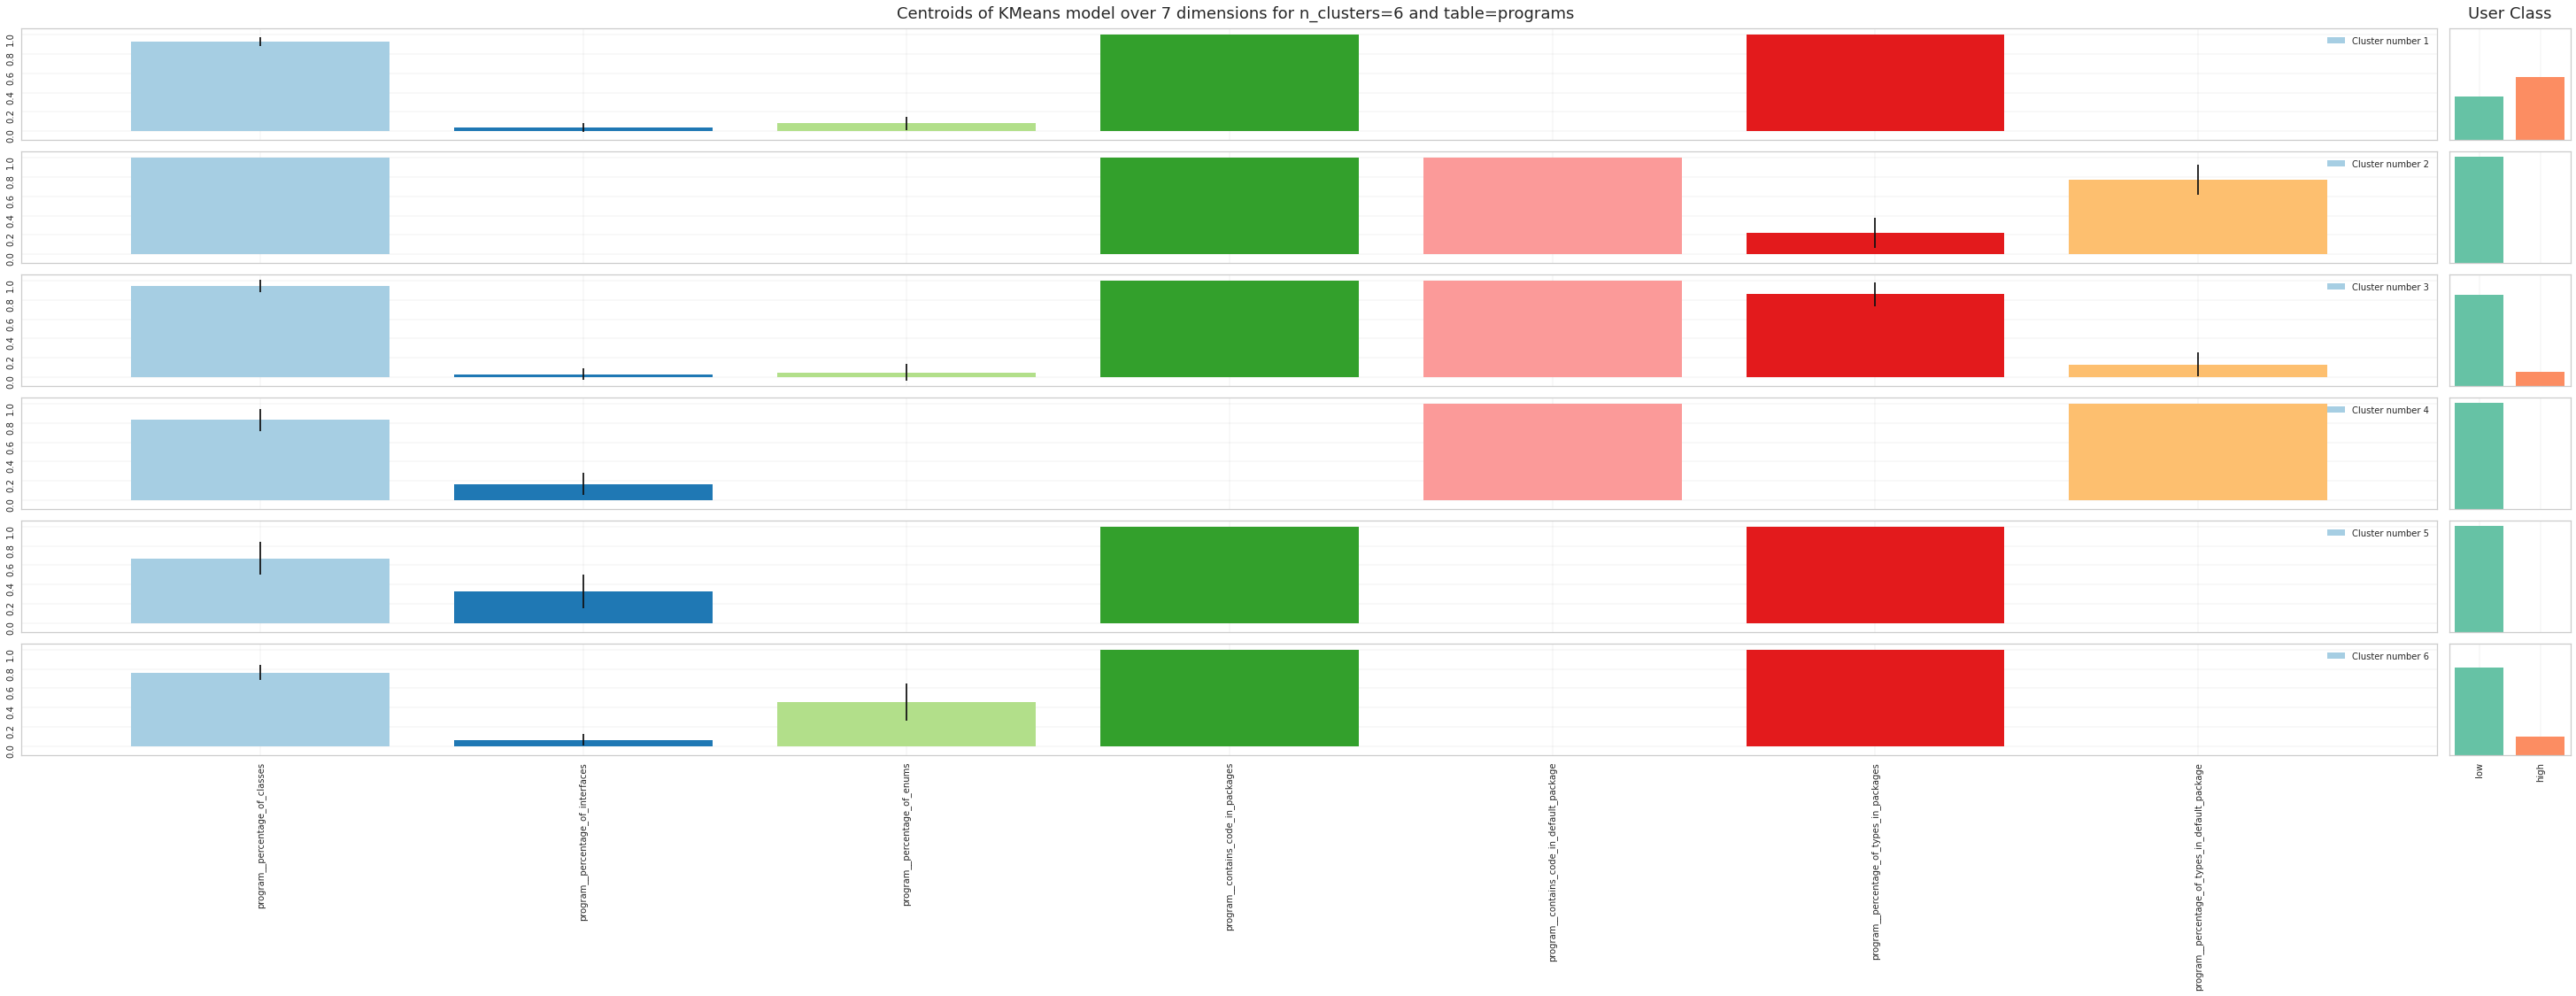

In [26]:
kmeans_model = KMeans(random_state=0, n_clusters=KMEANS_ELBOW_WO_DUPLICATES)

plot_cluster_model_centroids(kmeans_model, X_wo_duplicates, X_wo_duplicates, y_wo_duplicates)